# Clean Product Titles

In [1]:
# CATEGORY = "Baby_Products"
CATEGORY = "Video_Games"

# Define sequence lengths
MIN_SEQUENCE_LENGTH = 3
MAX_SEQUENCE_LENGTH = 100  # Adjust as needed

In [2]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
sys.path.append(str(PROJECT_ROOT))

# Data directory
DATA_DIR = Path(PROJECT_ROOT, "data")
DATA_DIR.mkdir(exist_ok=True)

In [3]:
import csv
import json
import logging
import os
import threading
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from dotenv import load_dotenv
from google import genai
from IPython.display import display
from polars.exceptions import NoDataError
from tqdm.notebook import tqdm

from src.logger import setup_logger

# Set environment variables to reduce Google API verbosity
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

logger = setup_logger("clean-items")
logging.getLogger("httpcore").setLevel(logging.WARNING)
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("google_genai").setLevel(logging.WARNING)

In [4]:
load_dotenv()

True

In [5]:
# API settings
MODEL = "gemini-2.5-flash-lite"
BATCH_SIZE: int = 10  # Items per API call (can process more titles at once)
MAX_RETRIES: int = 5
RETRY_DELAY: float = 1.0  # Seconds
RATE_LIMIT_DELAY: float = 0.1  # Seconds between API calls (faster for shorter text)
MAX_THREADS: int = 15  # Can use more threads for shorter text

# Text processing settings for titles
MAX_TITLE_LENGTH: int = 200  # Truncate titles before sending to API
MIN_TITLE_LENGTH: int = 10  # Minimum length to consider valid

## 2. Load Data and Analyze Titles

In [6]:
# Load the data
df = pl.read_parquet(DATA_DIR / "output" / f"{CATEGORY}_items.parquet")
logger.info(f"Loaded {len(df):,} items from {DATA_DIR / 'output' / f'{CATEGORY}_items.parquet'}")

# Display basic information
print(f"Total items: {len(df):,}")
print(f"Columns: {df.columns}")
display(df.head(5).select(["parent_asin", "title"]))

22:01:47 - Loaded 66,133 items from /home/zihao/llm/semantic-ids-llm/data/output/Video_Games_items.parquet
Total items: 66,133
Columns: ['parent_asin', 'title', 'description_text', 'features_text', 'main_category', 'categories_text', 'store', 'average_rating', 'rating_number', 'price', 'item_context']


parent_asin,title
str,str
"""B000FH0MHO""","""Dash 8-300 Professional Add-On"""
"""B00Z9TLVK0""","""NBA 2K17 - Early Tip Off Editi…"
"""B002WH4ZJG""","""Thrustmaster Elite Fitness Pac…"
"""B0001ZNU56""","""Spongebob Squarepants, Vol. 1"""
"""B009C9E8JY""","""Set of 4 Bullet Buttons Nickel…"


In [7]:
# Analyze title quality issues
def analyze_title_quality(df: pl.DataFrame) -> Dict:
    """Analyze title quality issues in the dataset."""
    stats = {}

    # Length statistics
    title_lengths = df["title"].str.len_chars()

    stats["title_lengths"] = {
        "min_length": title_lengths.min(),
        "max_length": title_lengths.max(),
        "mean_length": title_lengths.mean(),
        "median_length": title_lengths.median(),
        "empty_count": (title_lengths == 0).sum(),
        "too_long_count": (title_lengths > 150).sum(),
        "too_short_count": (title_lengths < 10).sum(),
    }

    # Check for common issues
    stats["issues"] = {
        "all_caps": df.filter(pl.col("title") == pl.col("title").str.to_uppercase()).shape[0],
        "excessive_punctuation": df.filter(pl.col("title").str.contains(r"[!]{2,}|[?]{2,}|[.]{3,}")).shape[0],
        "promotional_text": df.filter(
            pl.col("title").str.to_uppercase().str.contains(r"NEW!|SALE|LIMITED|EXCLUSIVE|SPECIAL")
        ).shape[0],
        "special_chars": df.filter(pl.col("title").str.contains(r"[★☆♥♦♠♣©®™]")).shape[0],
        "parentheses_overuse": df.filter(pl.col("title").str.count_matches(r"\(").ge(3)).shape[0],
        # Simplified check for platform mentions (removed backreference)
        "has_platform_keywords": df.filter(
            pl.col("title").str.to_lowercase().str.contains(r"playstation|xbox|nintendo|switch|ps[0-9]|pc")
        ).shape[0],
    }

    return stats


initial_stats = analyze_title_quality(df)
logger.info("Initial Title Quality Analysis:")
logger.info(json.dumps(initial_stats, indent=2, default=str))

22:01:51 - Initial Title Quality Analysis:
22:01:51 - {
  "title_lengths": {
    "min_length": 21,
    "max_length": 620,
    "mean_length": 75.7560673188877,
    "median_length": 55.0,
    "empty_count": 0,
    "too_long_count": 8470,
    "too_short_count": 0
  },
  "issues": {
    "all_caps": 285,
    "excessive_punctuation": 67,
    "promotional_text": 1365,
    "special_chars": 572,
    "parentheses_overuse": 90,
    "has_platform_keywords": 40997
  }
}


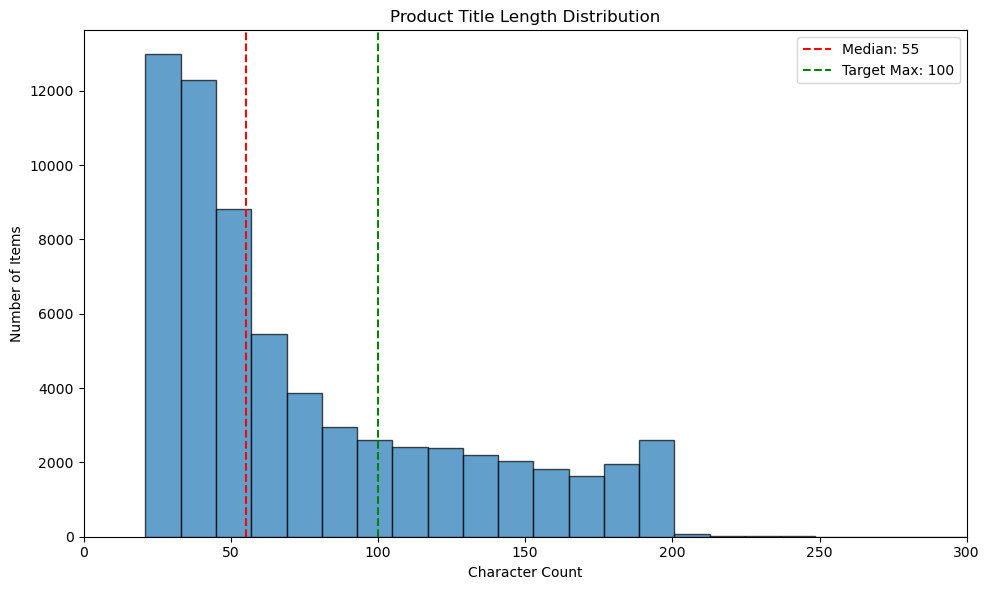


Example titles by length:

Short titles (< 30 chars):
  - Spongebob Squarepants, Vol. 1 (29 chars)
  - Tiger Heli - Nintendo NES (25 chars)
  - MX vs ATV Reflex [Download] (27 chars)

Long titles (> 150 chars):
  - TXEsign Wall Mount Holder for Nintendo Switch Dock Station Adhesive Small Wall Shelf Floating Wall M... (153 chars)
  - Deep Tissue Percussion Muscle Cellulite Massager,Handheld Electric Full Body Therapy Massage Gun for... (193 chars)
  - 10FT Long PS4 Charger Cord for Xbox One Controller,PS4 Charging Cable,Micro USB Cable for Xbox One S... (187 chars)


In [8]:
# Visualize title length distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Title lengths
title_lengths = df["title"].str.len_chars().to_list()
ax.hist(title_lengths, bins=50, edgecolor="black", alpha=0.7, cumulative=False)
ax.axvline(np.median(title_lengths), color="red", linestyle="--", label=f"Median: {np.median(title_lengths):.0f}")
ax.axvline(100, color="green", linestyle="--", label="Target Max: 100")
ax.set_xlabel("Character Count")
ax.set_ylabel("Number of Items")
ax.set_title("Product Title Length Distribution")
ax.legend()
ax.set_xlim(0, min(300, max(title_lengths)))

plt.tight_layout()
plt.show()

# Show some example titles of different lengths
print("\nExample titles by length:")
print("\nShort titles (< 30 chars):")
short_titles = df.filter(pl.col("title").str.len_chars() < 30).head(3)
for row in short_titles.iter_rows(named=True):
    print(f"  - {row['title']} ({len(row['title'])} chars)")

print("\nLong titles (> 150 chars):")
long_titles = df.filter(pl.col("title").str.len_chars() > 150).head(3)
for row in long_titles.iter_rows(named=True):
    print(f"  - {row['title'][:100]}... ({len(row['title'])} chars)")

# Initialize Gemini client

In [9]:
client = genai.Client()
logger.info("Gemini client initialized successfully")

22:02:01 - Gemini client initialized successfully


In [10]:
try:
    test_response = client.models.generate_content(
        model=MODEL, contents="Say 'API connection successful' if you can read this."
    )
    logger.info(f"API Test: {test_response.text}")
except Exception as e:
    logger.error(f"Failed to initialize Gemini client: {e}")
    logger.error("Please ensure GEMINI_API_KEY environment variable is set")
    raise

22:02:05 - API Test: API connection successful


## 4. Define Title Cleaning Functions

In [11]:
PROMPT = """Gemini, you are a data cleaning expert who rewrites product titles to be clear, concise, and well-formatted.

Rewrite the following product title to be clear, concise, and well-formatted.

Instructions:
1. Remove promotional text (NEW!, SALE!, LIMITED!, etc.)
2. Fix capitalization - use proper title case
3. Remove excessive punctuation and special characters (keep only necessary ones)
4. Remove duplicate or redundant information
5. Keep important details: brand names, model numbers, key specifications
6. Remove seller/store information
7. Fix spelling and grammar errors
8. Standardize abbreviations (e.g., "Ed." → "Edition", "w/" → "with")
9. Remove platform redundancy if already clear from context
10. Keep the title under 200 characters while preserving all key information

IMPORTANT: The cleaned title should be search-friendly and professional.

Product title to clean:
<title>
{title}
</title>

Return ONLY the cleaned title within <clean_title> tags.

Cleaned title: 
""".strip()

In [12]:
# CLEAN TITLE
def clean_title(prompt: str, title: str, model: str = MODEL) -> str:
    """
    Send a prompt and title to Gemini API for cleaning.

    Args:
        prompt: The cleaning instructions prompt
        title: The product title to clean
        model: The Gemini model to use (defaults to MODEL constant)

    Returns:
        Cleaned title text from Gemini
    """
    attempt = 0
    while attempt < MAX_RETRIES:
        try:
            # Format the full prompt with the title
            full_prompt = prompt.format(title=title)

            # Generate content using Gemini
            response = client.models.generate_content(model=model, contents=full_prompt)

            # Extract the cleaned text from response
            cleaned_text = f"{response.text.strip()}"

            # Extract content between tags if present
            if "<clean_title>" in cleaned_text and "</clean_title>" in cleaned_text:
                start = cleaned_text.find("<clean_title>") + len("<clean_title>")
                end = cleaned_text.find("</clean_title>")
                cleaned_text = cleaned_text[start:end].strip()

                # Validate the cleaned title
                if len(cleaned_text) > 0 and len(cleaned_text) <= MAX_TITLE_LENGTH:
                    return cleaned_text
                else:
                    # If title is empty or too long, retry
                    attempt += 1
                    if attempt < MAX_RETRIES:
                        logger.warning(
                            f"Invalid title length ({len(cleaned_text)}), retrying... (attempt {attempt}/{MAX_RETRIES})"
                        )
                        time.sleep(RETRY_DELAY)
                    continue
            else:
                # If tags not found, increment attempt and retry
                attempt += 1
                if attempt < MAX_RETRIES:
                    logger.warning(f"Tags not found in response, retrying... (attempt {attempt}/{MAX_RETRIES})")
                    time.sleep(RETRY_DELAY)
                continue

        except Exception as e:
            attempt += 1
            if attempt < MAX_RETRIES:
                logger.warning(f"Error cleaning with Gemini: {e}, retrying... (attempt {attempt}/{MAX_RETRIES})")
                time.sleep(RETRY_DELAY)
            else:
                logger.error(f"Failed after {MAX_RETRIES} attempts: {e}")

    # Return original title if all attempts fail
    logger.warning(f"🚨 Returning 'NA' after {MAX_RETRIES} failed attempts")
    return "NA"


# Test the function with a sample title
test_title = df.head(1).select("title").item()
cleaned = clean_title(PROMPT, test_title)
logger.info(f"Original: {test_title}")
logger.info(f"Cleaned: {cleaned}")

22:02:15 - Original: Dash 8-300 Professional Add-On
22:02:15 - Cleaned: Dash 8-300 Professional Add-On


## 5. Parallel Title Processing with Checkpointing

In [13]:
# Setup checkpoint file
checkpoint_file = DATA_DIR / "output" / f"{CATEGORY}_titles_clean.csv"

# Load existing processed ASINs if checkpoint exists
processed_asins = set()
if checkpoint_file.exists():
    try:
        existing_df = pl.read_csv(checkpoint_file)
        existing_df = existing_df.filter(pl.col("clean_title") != "NA")
        processed_asins = set(existing_df["parent_asin"])
        logger.info(f"Found {len(processed_asins):,} already processed items in checkpoint file")
    except NoDataError as e:
        logger.error(f"CSV is empty: {e}")
        processed_asins = set()
else:
    # Create new CSV with headers
    with open(checkpoint_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["parent_asin", "clean_title"])
    logger.info(f"Created new checkpoint file: {checkpoint_file}")

# Filter to only unprocessed items
items_to_process = df.filter(~pl.col("parent_asin").is_in(processed_asins))
logger.info(f"Items to process: {len(items_to_process):,} out of {len(df):,} total items")

# Thread-safe CSV writing lock
csv_lock = threading.Lock()


def process_single_title(item_data):
    """Process a single title and save to CSV."""
    asin, title = item_data

    try:
        # Truncate title if too long
        if len(title) > MAX_TITLE_LENGTH:
            title = title[:MAX_TITLE_LENGTH]

        # Clean the title
        cleaned = clean_title(PROMPT, title)

        # Write immediately to CSV with lock
        with csv_lock:
            with open(checkpoint_file, "a", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([asin, cleaned])

        # Rate limiting
        time.sleep(RATE_LIMIT_DELAY)

        return asin, cleaned, True

    except Exception as e:
        logger.error(f"Failed to process {asin}: {e}")
        # Save the original title if processing fails
        with csv_lock:
            with open(checkpoint_file, "a", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([asin, title])
        return asin, title, False


# Prepare items for processing
items = [(row["parent_asin"], row["title"]) for row in items_to_process.iter_rows(named=True)]

if len(items) > 0:
    logger.info(f"Starting parallel processing with {MAX_THREADS} workers...")

    # Process with ThreadPoolExecutor
    successful = 0
    failed = 0

    with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        # Submit all tasks
        futures = {executor.submit(process_single_title, item): item for item in items}

        # Process completions with progress bar
        with tqdm(total=len(futures), desc="Processing titles") as pbar:
            for future in as_completed(futures):
                try:
                    asin, result, success = future.result()
                    if success:
                        successful += 1
                    else:
                        failed += 1
                    pbar.update(1)
                    pbar.set_postfix({"success": successful, "failed": failed})

                except Exception as e:
                    failed += 1
                    pbar.update(1)
                    pbar.set_postfix({"success": successful, "failed": failed})
                    logger.error(f"Future failed: {e}")

    logger.info(f"Processing complete! Successful: {successful:,}, Failed: {failed:,}")

else:
    logger.info("No items to process - all items already in checkpoint file!")

22:02:27 - Created new checkpoint file: /home/zihao/llm/semantic-ids-llm/data/output/Video_Games_titles_clean.csv
22:02:27 - Items to process: 66,133 out of 66,133 total items
22:02:27 - Starting parallel processing with 15 workers...


Processing titles:   0%|          | 0/66133 [00:00<?, ?it/s]

22:02:38 - Error cleaning with Gemini: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}, retrying... (attempt 1/5)
22:03:55 - Error cleaning with Gemini: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}, retrying... (attempt 1/5)
22:03:56 - Error cleaning with Gemini: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}, retrying... (attempt 1/5)
22:03:56 - Error cleaning with Gemini: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}, retrying... (attempt 1/5)
22:03:58 - Error cleaning with Gemini: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}, retrying... (attempt 1/5)
22:04:55 - Error cle

## 6. Verify and Analyze Cleaned Titles

In [14]:
# Load and verify the cleaned titles
if checkpoint_file.exists():
    cleaned_df = pl.read_csv(checkpoint_file)
    logger.info(f"Loaded {len(cleaned_df):,} cleaned titles from {checkpoint_file}")

    # Display sample of cleaned data
    logger.info("Sample of cleaned titles:")
    display(cleaned_df.head(3))

else:
    logger.warning("No checkpoint file found. Run the processing cell first.")

10:03:00 - Loaded 66,133 cleaned titles from /home/zihao/llm/semantic-ids-llm/data/output/Video_Games_titles_clean.csv
10:03:00 - Sample of cleaned titles:


parent_asin,clean_title
str,str
"""B00BJH85SW""","""Turbo: Super Stunt Squad - Nin…"
"""B00006969T""","""Konami Collector's Series: Cas…"
"""B009C9E8JY""","""Set of 4 Bullet Buttons for Pl…"


In [15]:
pl.Config.set_fmt_str_lengths(2000)
cleaned_df.filter(pl.col("clean_title").str.contains("<")).select(["clean_title"]).tail(10)

clean_title
str
"""TWICE The 3rd Album: Formula of Love: O+T=<3 (Result File Ver.) Photobook, CD-R, Photocard, Twind Photo, Folded Poster"""
